## ЙОУ!
## Сегодня в очередной раз речь пойдёт о найстройке гиперпараметров

#### 3 - Тематический: научим машину самостоятельно искать оптимум, а также поговорим про оптимизацию в общем и целом (1,5 часа):
- можем ли мы заставить компьютер искать гиперпараметры (спойлер - да)
- сравним результаты GridSearchCV и OPTUNA
- усложним задачу - будем использовать OPTUNA для поиска оптимумов у функций
- мы все забыли про один гиперпараметр в классификации, и это...  
                ...я расскажу в конце ;)

### Модули

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [3]:
demand_train = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/demand_forecast_kaggle/demand_train.csv')
item_category_description = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/demand_forecast_kaggle/item_category_description.csv')

In [34]:
demand_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,26.01.2013,0,19,19164,399.0,4.0
1,28.01.2013,0,19,19166,549.0,1.0
2,06.01.2013,0,19,19186,149.0,1.0
3,16.01.2013,0,19,19186,149.0,1.0
4,13.01.2013,0,19,19187,349.0,1.0
...,...,...,...,...,...,...
532940,04.05.2015,28,46,15835,249.0,1.0
532941,01.05.2015,28,46,16450,149.0,1.0
532942,11.05.2015,28,46,16459,399.0,1.0
532943,26.05.2015,28,46,15780,229.0,1.0


In [36]:
demand_train = demand_train.merge(item_category_description, on=['item_id'], how='left')

In [37]:
demand_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,26.01.2013,0,19,19164,399.0,4.0,40
1,28.01.2013,0,19,19166,549.0,1.0,37
2,06.01.2013,0,19,19186,149.0,1.0,40
3,16.01.2013,0,19,19186,149.0,1.0,40
4,13.01.2013,0,19,19187,349.0,1.0,40
...,...,...,...,...,...,...,...
532940,04.05.2015,28,46,15835,249.0,1.0,40
532941,01.05.2015,28,46,16450,149.0,1.0,40
532942,11.05.2015,28,46,16459,399.0,1.0,55
532943,26.05.2015,28,46,15780,229.0,1.0,55


In [38]:
X = demand_train.drop(['item_cnt_day', 'date'], 1)
y = demand_train.item_cnt_day

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=12
)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_92952/2323193959.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = demand_train.drop(['item_cnt_day', 'date'], 1)


<AxesSubplot:xlabel='item_cnt_day', ylabel='Count'>

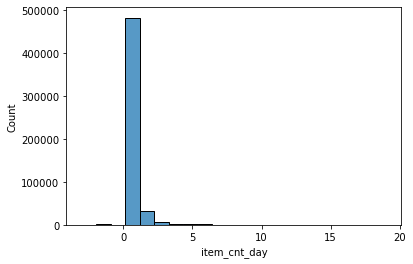

In [44]:
sns.histplot(demand_train.query('item_cnt_day < 20').item_cnt_day)

In [71]:
%%time

parameters = {
    'n_estimators': [100, 400, 800],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 6]
}

cbc = CatBoostRegressor(verbose=False, loss_function='RMSE')
clf = GridSearchCV(cbc, parameters, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 32.8 s, sys: 2.94 s, total: 35.7 s
Wall time: 2min 39s


GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc43c2d68e0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [5, 6],
                         'n_estimators': [100, 400, 800]},
             scoring='neg_root_mean_squared_error')

In [72]:
clf.best_score_

-1.2071022272802894

In [73]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 800}

In [74]:
mse(clf.best_estimator_.predict(X_test), y_test) ** .5

1.4606941900799983

### Про Optuna

In [ ]:
def objective(trial):

    objective_ = trial.suggest_categorical("objective", ["RMSE", "MAE"]),
    depth = trial.suggest_int("depth", 5, 6),
    n_estimators = trial.suggest_int('n_estimators', 300, 700, log=True),
    learning_rate = trial.suggest_float('learning_rate', 0.14, 0.2)

    gbm = CatBoostRegressor(
        objective=objective_, 
        depth=depth, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate
    )

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    accuracy = mse(y_test, gbm.predict(X_test)) ** .5

    return accuracy

In [50]:
def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["RMSE", "MAE"]),
        "depth": trial.suggest_int("depth", 5, 6),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.14, 0.2, log=True)
    }

    gbm = CatBoostRegressor(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    accuracy = mse(y_test, gbm.predict(X_test)) ** .5

    return accuracy

In [58]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=45, timeout=600, n_jobs=-1)

[I 2022-07-28 19:45:58,883] A new study created in memory with name: no-name-fe0e5bbb-6f48-481b-8285-75aafce49255
/Users/kirillsokolov/opt/anaconda3/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-07-28 19:47:57,629] Trial 33 finished with value: 1.4528600673753347 and parameters: {'objective': 'RMSE', 'depth': 6, 'n_estimators': 408, 'learning_rate': 0.16259689133190972}. Best is trial 3 with value: 1.4521360493031787.
[I 2022-07-28 19:47:57,842] Trial 26 finished with value: 1.5806647840063714 and parameters: {'objective': 'MAE', 'depth': 6, 'n_estimators': 697, 'learning_rate': 0.1982722939880385}. Best is trial 3 with value: 1.4521360493031787.
[I 2022-07-28 19:47:58,308] Trial 29 finished with value: 1.449143955177119 and parameters: {'objective': 'RMSE', 'depth': 6, 'n_estimators': 680, 'learning_rate': 0.19440905740464393}. Best is trial 29 with value: 1.449143955177119.
[I 2022-07-28 19:47:59,071] Trial 34 finished with value: 1.4565460816366786 and parameters: {'objective': 'RMSE', 'depth': 6, 'n_estimators': 403, 'learning_rate': 0.16417316363587753}. Best is trial 

CPU times: user 19min 45s, sys: 18.4 s, total: 20min 4s
Wall time: 2min 23s


In [59]:
study.best_params

{'objective': 'RMSE',
 'depth': 6,
 'n_estimators': 680,
 'learning_rate': 0.19440905740464393}

In [60]:
study.best_value

1.449143955177119

In [66]:
cbr = CatBoostRegressor(**study.best_params)

In [67]:
cbr.fit(X_train, y_train)

0:	learn: 1.3765083	total: 9.84ms	remaining: 6.68s
1:	learn: 1.3563185	total: 18.4ms	remaining: 6.23s
2:	learn: 1.3453970	total: 31ms	remaining: 6.99s
3:	learn: 1.3349203	total: 41.4ms	remaining: 6.99s
4:	learn: 1.3267757	total: 51.9ms	remaining: 7s
5:	learn: 1.3228372	total: 60.7ms	remaining: 6.82s
6:	learn: 1.3194060	total: 70.4ms	remaining: 6.76s
7:	learn: 1.3162804	total: 80.1ms	remaining: 6.72s
8:	learn: 1.3139956	total: 89.9ms	remaining: 6.7s
9:	learn: 1.3076764	total: 100ms	remaining: 6.71s
10:	learn: 1.3044682	total: 110ms	remaining: 6.7s
11:	learn: 1.2970476	total: 121ms	remaining: 6.74s
12:	learn: 1.2957017	total: 131ms	remaining: 6.7s
13:	learn: 1.2931726	total: 141ms	remaining: 6.7s
14:	learn: 1.2903574	total: 152ms	remaining: 6.73s
15:	learn: 1.2892228	total: 161ms	remaining: 6.7s
16:	learn: 1.2878592	total: 171ms	remaining: 6.68s
17:	learn: 1.2865526	total: 187ms	remaining: 6.86s
18:	learn: 1.2837034	total: 197ms	remaining: 6.86s
19:	learn: 1.2802175	total: 207ms	remainin

161:	learn: 1.2017889	total: 1.83s	remaining: 5.86s
162:	learn: 1.2008694	total: 1.85s	remaining: 5.86s
163:	learn: 1.2006443	total: 1.86s	remaining: 5.85s
164:	learn: 1.2004695	total: 1.87s	remaining: 5.84s
165:	learn: 1.2002665	total: 1.88s	remaining: 5.82s
166:	learn: 1.1998737	total: 1.89s	remaining: 5.82s
167:	learn: 1.1994175	total: 1.91s	remaining: 5.81s
168:	learn: 1.1993460	total: 1.92s	remaining: 5.8s
169:	learn: 1.1991242	total: 1.93s	remaining: 5.8s
170:	learn: 1.1988775	total: 1.95s	remaining: 5.8s
171:	learn: 1.1985491	total: 1.96s	remaining: 5.79s
172:	learn: 1.1984569	total: 1.98s	remaining: 5.8s
173:	learn: 1.1983404	total: 1.99s	remaining: 5.78s
174:	learn: 1.1981162	total: 2s	remaining: 5.77s
175:	learn: 1.1978563	total: 2.01s	remaining: 5.76s
176:	learn: 1.1977196	total: 2.02s	remaining: 5.74s
177:	learn: 1.1974173	total: 2.03s	remaining: 5.73s
178:	learn: 1.1972940	total: 2.04s	remaining: 5.71s
179:	learn: 1.1970907	total: 2.05s	remaining: 5.71s
180:	learn: 1.19700

331:	learn: 1.1646979	total: 3.86s	remaining: 4.05s
332:	learn: 1.1646171	total: 3.88s	remaining: 4.04s
333:	learn: 1.1645044	total: 3.89s	remaining: 4.03s
334:	learn: 1.1643670	total: 3.9s	remaining: 4.01s
335:	learn: 1.1642596	total: 3.91s	remaining: 4s
336:	learn: 1.1641610	total: 3.92s	remaining: 3.99s
337:	learn: 1.1640437	total: 3.93s	remaining: 3.98s
338:	learn: 1.1639638	total: 3.94s	remaining: 3.96s
339:	learn: 1.1639171	total: 3.95s	remaining: 3.95s
340:	learn: 1.1638057	total: 3.96s	remaining: 3.94s
341:	learn: 1.1637043	total: 3.97s	remaining: 3.92s
342:	learn: 1.1636485	total: 3.98s	remaining: 3.91s
343:	learn: 1.1636063	total: 3.99s	remaining: 3.9s
344:	learn: 1.1634875	total: 4s	remaining: 3.89s
345:	learn: 1.1633555	total: 4.01s	remaining: 3.87s
346:	learn: 1.1633110	total: 4.02s	remaining: 3.86s
347:	learn: 1.1632400	total: 4.04s	remaining: 3.85s
348:	learn: 1.1630302	total: 4.05s	remaining: 3.84s
349:	learn: 1.1628476	total: 4.06s	remaining: 3.83s
350:	learn: 1.162782

504:	learn: 1.1407241	total: 5.88s	remaining: 2.04s
505:	learn: 1.1404536	total: 5.9s	remaining: 2.03s
506:	learn: 1.1400719	total: 5.91s	remaining: 2.02s
507:	learn: 1.1400557	total: 5.92s	remaining: 2s
508:	learn: 1.1396289	total: 5.93s	remaining: 1.99s
509:	learn: 1.1395891	total: 5.94s	remaining: 1.98s
510:	learn: 1.1393015	total: 5.95s	remaining: 1.97s
511:	learn: 1.1392734	total: 5.96s	remaining: 1.96s
512:	learn: 1.1392077	total: 5.97s	remaining: 1.94s
513:	learn: 1.1388079	total: 5.98s	remaining: 1.93s
514:	learn: 1.1387413	total: 5.99s	remaining: 1.92s
515:	learn: 1.1387080	total: 6s	remaining: 1.91s
516:	learn: 1.1386715	total: 6.01s	remaining: 1.9s
517:	learn: 1.1386212	total: 6.02s	remaining: 1.88s
518:	learn: 1.1386015	total: 6.03s	remaining: 1.87s
519:	learn: 1.1385144	total: 6.05s	remaining: 1.86s
520:	learn: 1.1384755	total: 6.06s	remaining: 1.85s
521:	learn: 1.1384546	total: 6.07s	remaining: 1.84s
522:	learn: 1.1384368	total: 6.08s	remaining: 1.82s
523:	learn: 1.138405

677:	learn: 1.1248463	total: 7.94s	remaining: 23.4ms
678:	learn: 1.1248355	total: 7.95s	remaining: 11.7ms
679:	learn: 1.1247601	total: 7.96s	remaining: 0us


### Как ещё можно использовать Optuna?

In [70]:
def objective(trial):
    
    x = trial.suggest_float('x', -100, 100)
    
    accuracy = (x - 2) ** 2
    
    return accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

study.best_params

[I 2022-07-28 20:04:08,598] A new study created in memory with name: no-name-17a351cb-74ab-4bc2-8fc4-262013cef350
[I 2022-07-28 20:04:08,612] Trial 0 finished with value: 3357.989693416707 and parameters: {'x': 59.948163848535415}. Best is trial 0 with value: 3357.989693416707.
[I 2022-07-28 20:04:08,614] Trial 1 finished with value: 1498.6213653804907 and parameters: {'x': -36.71203127427558}. Best is trial 1 with value: 1498.6213653804907.
[I 2022-07-28 20:04:08,615] Trial 2 finished with value: 131.2456728323852 and parameters: {'x': -9.456250382755485}. Best is trial 2 with value: 131.2456728323852.
[I 2022-07-28 20:04:08,616] Trial 3 finished with value: 258.3853419875559 and parameters: {'x': -14.074369100762738}. Best is trial 2 with value: 131.2456728323852.
[I 2022-07-28 20:04:08,618] Trial 4 finished with value: 8.098848958890423 and parameters: {'x': -0.8458476696566919}. Best is trial 4 with value: 8.098848958890423.
[I 2022-07-28 20:04:08,619] Trial 5 finished with value: 

[I 2022-07-28 20:04:08,752] Trial 45 finished with value: 0.35143854704964944 and parameters: {'x': 2.5928225257609983}. Best is trial 19 with value: 0.06979439962871484.
[I 2022-07-28 20:04:08,755] Trial 46 finished with value: 290.1736322584459 and parameters: {'x': 19.0344836217141}. Best is trial 19 with value: 0.06979439962871484.
[I 2022-07-28 20:04:08,758] Trial 47 finished with value: 947.2871620288751 and parameters: {'x': -28.778030509258954}. Best is trial 19 with value: 0.06979439962871484.
[I 2022-07-28 20:04:08,762] Trial 48 finished with value: 9901.123044619755 and parameters: {'x': -97.5043870621781}. Best is trial 19 with value: 0.06979439962871484.
[I 2022-07-28 20:04:08,766] Trial 49 finished with value: 0.052826086135042756 and parameters: {'x': 1.7701607384822107}. Best is trial 49 with value: 0.052826086135042756.
[I 2022-07-28 20:04:08,769] Trial 50 finished with value: 641.9350875508295 and parameters: {'x': 27.336437941250335}. Best is trial 49 with value: 0.0

[I 2022-07-28 20:04:08,931] Trial 90 finished with value: 287.094027912848 and parameters: {'x': 18.943849264935285}. Best is trial 49 with value: 0.052826086135042756.
[I 2022-07-28 20:04:08,934] Trial 91 finished with value: 0.017160394490650627 and parameters: {'x': 1.8690023111247736}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:08,939] Trial 92 finished with value: 1.6100308606663467 and parameters: {'x': 3.2688699147928233}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:08,942] Trial 93 finished with value: 31.32408053372383 and parameters: {'x': -3.5967919859258513}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:08,946] Trial 94 finished with value: 820.0621956454668 and parameters: {'x': 30.636728089037454}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:08,950] Trial 95 finished with value: 166.4716808122641 and parameters: {'x': 14.902390507664233}. Best is trial 91 with value

[I 2022-07-28 20:04:09,111] Trial 135 finished with value: 147.7692972052516 and parameters: {'x': 14.156039536183304}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:09,115] Trial 136 finished with value: 16.549120237314636 and parameters: {'x': -2.068060992329716}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:09,119] Trial 137 finished with value: 180.96347821889782 and parameters: {'x': -11.452266657292288}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:09,123] Trial 138 finished with value: 0.30445061264066775 and parameters: {'x': 2.551770434728672}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:09,128] Trial 139 finished with value: 90.02416020354556 and parameters: {'x': -7.4881062495919375}. Best is trial 91 with value: 0.017160394490650627.
[I 2022-07-28 20:04:09,133] Trial 140 finished with value: 295.92529514481765 and parameters: {'x': 19.20247933132947}. Best is trial 91 wit

[I 2022-07-28 20:04:09,298] Trial 180 finished with value: 220.14290097611973 and parameters: {'x': -12.837213383116108}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,303] Trial 181 finished with value: 1.91431875431788 and parameters: {'x': 3.383589084344727}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,307] Trial 182 finished with value: 0.0731496151486284 and parameters: {'x': 1.729538144743795}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,311] Trial 183 finished with value: 0.005309648511239297 and parameters: {'x': 1.9271326649915115}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,315] Trial 184 finished with value: 66.01437460497236 and parameters: {'x': 10.124923052249317}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,319] Trial 185 finished with value: 36.93561369925037 and parameters: {'x': -4.077467704500812}. Best is trial 148

[I 2022-07-28 20:04:09,493] Trial 225 finished with value: 0.7594975031271729 and parameters: {'x': 1.1285084606680493}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,497] Trial 226 finished with value: 62.87106794748213 and parameters: {'x': -5.929127817577551}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,502] Trial 227 finished with value: 11.32497230409007 and parameters: {'x': 5.3652596191215425}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,506] Trial 228 finished with value: 20.22751729405034 and parameters: {'x': -2.4975012277986477}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,511] Trial 229 finished with value: 0.011480505582839556 and parameters: {'x': 1.892852878793504}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,515] Trial 230 finished with value: 40.64562393637892 and parameters: {'x': 8.37539206138563}. Best is trial 148 

[I 2022-07-28 20:04:09,692] Trial 270 finished with value: 58.4679940552741 and parameters: {'x': 9.646436690071663}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,697] Trial 271 finished with value: 26.75585331118989 and parameters: {'x': -3.1726060463938186}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,702] Trial 272 finished with value: 13.753039866477167 and parameters: {'x': 5.70850911640745}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,707] Trial 273 finished with value: 1.4078427004063343 and parameters: {'x': 0.8134745260187903}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,712] Trial 274 finished with value: 8291.814736075143 and parameters: {'x': -89.05940223873174}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,717] Trial 275 finished with value: 89.9647769025453 and parameters: {'x': -7.484976378597117}. Best is trial 148 with

[I 2022-07-28 20:04:09,918] Trial 315 finished with value: 8.9805666332846 and parameters: {'x': -0.9967593552510352}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,922] Trial 316 finished with value: 65.48377669797594 and parameters: {'x': 10.092204687103258}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,927] Trial 317 finished with value: 9.083109904548419 and parameters: {'x': 5.013819819522796}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,932] Trial 318 finished with value: 47.56078283824421 and parameters: {'x': -4.896432616813145}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,937] Trial 319 finished with value: 1.8137449359405735 and parameters: {'x': 0.6532465199820074}. Best is trial 148 with value: 0.000117683925129252.
[I 2022-07-28 20:04:09,941] Trial 320 finished with value: 29.447714737268363 and parameters: {'x': 7.426574862403389}. Best is trial 148 wit

[I 2022-07-28 20:04:10,144] Trial 359 finished with value: 249.51489892579008 and parameters: {'x': -13.796040609146017}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,149] Trial 360 finished with value: 67.2868595075891 and parameters: {'x': 10.20285678941118}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,154] Trial 361 finished with value: 0.00819301425277346 and parameters: {'x': 2.090515270826383}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,159] Trial 362 finished with value: 2.52446181733433 and parameters: {'x': 0.4111444945073419}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,164] Trial 363 finished with value: 1243.2622674125264 and parameters: {'x': -33.25992438183222}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,169] Trial 364 finished with value: 79.2522070896411 and parameters: {'x': -6.902370869023661}. Best is trial 3

[I 2022-07-28 20:04:10,364] Trial 403 finished with value: 21.998739024934384 and parameters: {'x': -2.6902813375035812}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,369] Trial 404 finished with value: 0.11693030755043171 and parameters: {'x': 1.6580492615150075}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,374] Trial 405 finished with value: 20.850044488252205 and parameters: {'x': 6.5661848942253975}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,378] Trial 406 finished with value: 44.511780476339986 and parameters: {'x': -4.671714957665682}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,383] Trial 407 finished with value: 2.5953542830371394 and parameters: {'x': 0.3889896701022866}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,389] Trial 408 finished with value: 129.79501159886186 and parameters: {'x': -9.39276136846822}. Best is 

[I 2022-07-28 20:04:10,597] Trial 447 finished with value: 26.852842060688648 and parameters: {'x': -3.181972796212717}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,603] Trial 448 finished with value: 0.0011730747824370059 and parameters: {'x': 1.9657498206948196}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,609] Trial 449 finished with value: 59.18000791765791 and parameters: {'x': 9.692854341377972}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,615] Trial 450 finished with value: 0.18070043217544318 and parameters: {'x': 1.5749112655274864}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,621] Trial 451 finished with value: 163.63537298052134 and parameters: {'x': -10.792004259713227}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,626] Trial 452 finished with value: 12.124717753462436 and parameters: {'x': 5.482056540819295}. Best is

[I 2022-07-28 20:04:10,838] Trial 491 finished with value: 2.843942125405306 and parameters: {'x': 3.686399159572047}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,844] Trial 492 finished with value: 48.1633031449806 and parameters: {'x': -4.939978612717809}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,849] Trial 493 finished with value: 1.6909803998468866 and parameters: {'x': 0.6996229778072489}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,855] Trial 494 finished with value: 15.681473040381707 and parameters: {'x': 5.959983969712719}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,860] Trial 495 finished with value: 15.502063842319936 and parameters: {'x': -1.9372660365182255}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:10,866] Trial 496 finished with value: 138.31064780719717 and parameters: {'x': 13.7605547406233}. Best is trial 3

[I 2022-07-28 20:04:11,086] Trial 535 finished with value: 3.6962863683642633 and parameters: {'x': 3.9225728512501843}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,091] Trial 536 finished with value: 34.21727849890945 and parameters: {'x': -3.8495537008313248}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,097] Trial 537 finished with value: 0.8304127031889055 and parameters: {'x': 1.0887301699337866}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,102] Trial 538 finished with value: 22.840394615194658 and parameters: {'x': 6.779162543290891}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,108] Trial 539 finished with value: 159.08788834259724 and parameters: {'x': 14.613004730935339}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,114] Trial 540 finished with value: 19.54334375152087 and parameters: {'x': -2.42078542246973}. Best is tria

[I 2022-07-28 20:04:11,341] Trial 579 finished with value: 98.99682442491104 and parameters: {'x': 11.949714791134017}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,347] Trial 580 finished with value: 46.71786179872188 and parameters: {'x': -4.8350465835078165}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,354] Trial 581 finished with value: 2.801373060939421 and parameters: {'x': 0.3262697167884483}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,359] Trial 582 finished with value: 40.30146459275215 and parameters: {'x': 8.348343452645906}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,366] Trial 583 finished with value: 8.481889991602195 and parameters: {'x': 4.912368450523078}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,372] Trial 584 finished with value: 1768.8088426973347 and parameters: {'x': 44.057209164391004}. Best is trial 3

[I 2022-07-28 20:04:11,611] Trial 624 finished with value: 0.14574964383380018 and parameters: {'x': 1.6182282830881782}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,617] Trial 625 finished with value: 66.82737672121154 and parameters: {'x': -6.174801326100318}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,623] Trial 626 finished with value: 66.05362149653752 and parameters: {'x': 10.127337909582542}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,629] Trial 627 finished with value: 0.897507720247551 and parameters: {'x': 1.0526311593431252}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,635] Trial 628 finished with value: 268.90983074183004 and parameters: {'x': -14.398470378112409}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,641] Trial 629 finished with value: 9.037130817498035 and parameters: {'x': 5.0061820998565665}. Best is tri

[I 2022-07-28 20:04:11,877] Trial 668 finished with value: 117.59602390958057 and parameters: {'x': 12.844170042450486}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,883] Trial 669 finished with value: 45.38157634538456 and parameters: {'x': 8.736584917106335}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,889] Trial 670 finished with value: 87.85171847731064 and parameters: {'x': -7.372924755769175}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,896] Trial 671 finished with value: 0.1509469920747014 and parameters: {'x': 2.388518972605845}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,902] Trial 672 finished with value: 10.534500711990232 and parameters: {'x': -1.2456895587825758}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:11,909] Trial 673 finished with value: 6.615662791717627 and parameters: {'x': 4.572093076021478}. Best is trial 

[I 2022-07-28 20:04:12,150] Trial 712 finished with value: 16.254611323997846 and parameters: {'x': -2.0317007979260873}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,157] Trial 713 finished with value: 1.4709338480102236 and parameters: {'x': 3.2128206165836}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,163] Trial 714 finished with value: 35.48371746826576 and parameters: {'x': -3.9568210874816243}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,169] Trial 715 finished with value: 52.44347449196707 and parameters: {'x': 9.241786691968155}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,176] Trial 716 finished with value: 2.8126662024223896 and parameters: {'x': 0.3228994656185964}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,182] Trial 717 finished with value: 12.941035320272057 and parameters: {'x': 5.597365052406005}. Best is trial 

[I 2022-07-28 20:04:12,433] Trial 756 finished with value: 6.547021197907363 and parameters: {'x': -0.558714755088453}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,440] Trial 757 finished with value: 243.54714944574624 and parameters: {'x': -13.605997226891533}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,447] Trial 758 finished with value: 75.65964654785829 and parameters: {'x': -6.698255373801019}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,454] Trial 759 finished with value: 1.2156761419175743 and parameters: {'x': 3.1025770457966075}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,460] Trial 760 finished with value: 71.8503450378826 and parameters: {'x': 10.476458283851965}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,467] Trial 761 finished with value: 17.59903348007105 and parameters: {'x': -2.195120198524835}. Best is trial

[I 2022-07-28 20:04:12,723] Trial 800 finished with value: 5.179781473457692 and parameters: {'x': -0.2759133273166823}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,730] Trial 801 finished with value: 11.716648198455694 and parameters: {'x': 5.4229589828766125}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,737] Trial 802 finished with value: 83.30711621380559 and parameters: {'x': -7.127273208018131}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,743] Trial 803 finished with value: 1.4094807234442592 and parameters: {'x': 0.8127844663060295}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,750] Trial 804 finished with value: 61.05658333299096 and parameters: {'x': 9.81387121297702}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:12,756] Trial 805 finished with value: 37.25501518614729 and parameters: {'x': -4.103688654096578}. Best is trial 

[I 2022-07-28 20:04:13,016] Trial 844 finished with value: 3.0577137374311727 and parameters: {'x': 3.7486319616863844}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,023] Trial 845 finished with value: 56.44770892629658 and parameters: {'x': 9.513169033523509}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,029] Trial 846 finished with value: 182.8538343302055 and parameters: {'x': -11.522345740669609}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,036] Trial 847 finished with value: 34.213005325200456 and parameters: {'x': -3.849188433039276}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,043] Trial 848 finished with value: 6761.344071401322 and parameters: {'x': -80.22739246383362}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,051] Trial 849 finished with value: 6.532158027564785 and parameters: {'x': 4.555808683678179}. Best is trial 

[I 2022-07-28 20:04:13,318] Trial 888 finished with value: 190.9525818967539 and parameters: {'x': 15.81855932782987}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,325] Trial 889 finished with value: 2.3998169475840663 and parameters: {'x': 0.4508657425568092}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,332] Trial 890 finished with value: 39.39901766352071 and parameters: {'x': -4.276863680495277}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,339] Trial 891 finished with value: 53.57842887499338 and parameters: {'x': 9.319728743265927}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,345] Trial 892 finished with value: 5.231437580782383 and parameters: {'x': 4.287233608703401}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,352] Trial 893 finished with value: 1.3232104562276092 and parameters: {'x': 0.8496911474618615}. Best is trial 32

[I 2022-07-28 20:04:13,622] Trial 932 finished with value: 37.24807212542444 and parameters: {'x': 8.103119868184177}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,680] Trial 933 finished with value: 32.066616838599934 and parameters: {'x': -3.662739340513559}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,687] Trial 934 finished with value: 0.6738042460558872 and parameters: {'x': 2.8208558010125087}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,695] Trial 935 finished with value: 4.435270688922959 and parameters: {'x': -0.10600823572059159}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,701] Trial 936 finished with value: 16.158220716061802 and parameters: {'x': 6.0197289356450145}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,708] Trial 937 finished with value: 75.21803444062463 and parameters: {'x': -6.672833126529337}. Best is tri

[I 2022-07-28 20:04:13,983] Trial 976 finished with value: 22.034240693977136 and parameters: {'x': -2.6940644109318677}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,990] Trial 977 finished with value: 0.4667053683139511 and parameters: {'x': 2.6831583771820053}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:13,998] Trial 978 finished with value: 159.28515398015844 and parameters: {'x': -10.620822238672028}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:14,005] Trial 979 finished with value: 45.87537478876148 and parameters: {'x': 8.773136259426757}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:14,012] Trial 980 finished with value: 7.4684175769109205 and parameters: {'x': -0.732840569244924}. Best is trial 325 with value: 7.082824018271536e-05.
[I 2022-07-28 20:04:14,019] Trial 981 finished with value: 5.022592777811366 and parameters: {'x': 4.241114182234222}. Best is tri

{'x': 1.9915840484683718}

### Hyperparameters Wars: Phantom Menace - или рассказ о скрытом гиперпараметре

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

In [5]:
weather = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/randomforest/AUS_train_dataset.csv')
X_test = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/randomforest/AUS_test_dataset.csv')
y_test = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/randomforest/hidden/answers_ranfo.csv').drop('id', 1)

medians_dict = {}

for col in weather.columns.drop('RainTomorrow'):
    medians_dict[col] = weather[col].median()

for col in weather.columns.drop('RainTomorrow'):
    weather[col] = weather[col].fillna(medians_dict[col])
    
for col in weather.columns.drop('RainTomorrow'):
    X_test[col] = X_test[col].fillna(medians_dict[col])


y_train = weather.RainTomorrow
X_train = weather.drop('RainTomorrow', 1)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_95310/32928140.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  y_test = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/randomforest/hidden/answers_ranfo.csv').drop('id', 1)
/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_95310/32928140.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = weather.drop('RainTomorrow', 1)


In [6]:
weather.RainTomorrow.mean()

0.21045548458024527

In [7]:
parameters = {
    'n_estimators': [160, 320],
    'max_depth': [14],
    'max_features': [4]
}

In [8]:
rf = RandomForestClassifier()

In [9]:
clf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=8, n_jobs=-1)

In [10]:
%%time
clf.fit(X_train, y_train)

CPU times: user 23.7 s, sys: 393 ms, total: 24.1 s
Wall time: 1min


GridSearchCV(cv=8, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [14], 'max_features': [4],
                         'n_estimators': [160, 320]},
             scoring='roc_auc')

In [11]:
clf.best_params_

{'max_depth': 14, 'max_features': 4, 'n_estimators': 320}

In [12]:
clf.best_estimator_

RandomForestClassifier(max_depth=14, max_features=4, n_estimators=320)

In [13]:
clf.best_score_

0.8715700364188996

In [14]:
f1_score(y_test, clf.best_estimator_.predict(X_test.drop('id', 1)))

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_95310/2680251070.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  f1_score(y_test, clf.best_estimator_.predict(X_test.drop('id', 1)))


0.5722341265365963

In [15]:
precision_score(y_test, clf.best_estimator_.predict(X_test.drop('id', 1)))

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_95310/3665562090.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  precision_score(y_test, clf.best_estimator_.predict(X_test.drop('id', 1)))


0.7564102564102564

In [16]:
recall_score(y_test, clf.best_estimator_.predict(X_test.drop('id', 1)))

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_95310/503025763.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  recall_score(y_test, clf.best_estimator_.predict(X_test.drop('id', 1)))


0.4601850172319971

In [17]:
print(classification_report(y_train, clf.best_estimator_.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     41654
           1       0.98      0.69      0.81     11103

    accuracy                           0.93     52757
   macro avg       0.95      0.84      0.88     52757
weighted avg       0.93      0.93      0.93     52757



In [18]:
print(confusion_matrix(y_train, clf.best_estimator_.predict(X_train)))

[[41490   164]
 [ 3461  7642]]


### Выбор оптимальной отсечки классификатора

In [19]:
predict = clf.best_estimator_.predict_proba(X_train)[:, 1]

In [20]:
predict

array([0.01814697, 0.10935941, 0.20210844, ..., 0.05628123, 0.09855987,
       0.0590747 ])

In [21]:
predict > .5

array([False, False, False, ..., False, False, False])

In [109]:
%%time
predict = clf.best_estimator_.predict_proba(X_train)[:, 1]
best_thres = 0.01
max_f_score = 0
for i in range(1, 100):
    thres = i / 100
    var = f1_score(y_train, list(map(int, predict >= thres)))
    if var > max_f_score:
        max_f_score = var
        best_thres = thres

CPU times: user 5.16 s, sys: 29.1 ms, total: 5.19 s
Wall time: 5.2 s


In [110]:
max_f_score

0.8599093141885509

In [112]:
best_thres

0.35

In [113]:
f1_score(y_test, list(map(int, clf.best_estimator_.predict_proba(X_test.drop('id', 1))[:, 1] >= .35)))

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_92952/2796117708.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  f1_score(y_test, list(map(int, clf.best_estimator_.predict_proba(X_test.drop('id', 1))[:, 1] > .35)))


0.6288726532877091